In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from tensorflow.keras import layers


folder = '/content/drive/MyDrive/dataset'
image_size = (224, 224)
batch_size = 32

In [29]:
train_img = tf.keras.utils.image_dataset_from_directory(
    folder + '/train',
    labels = 'inferred',
    image_size = image_size,
    batch_size = batch_size,
    color_mode = 'rgb',
    shuffle=True  
)
test_img = tf.keras.utils.image_dataset_from_directory(
    folder+'/test',
    labels = 'inferred',
    image_size = image_size,
    batch_size = batch_size,
    color_mode = 'rgb',
    shuffle=False 
)

Found 3620 files belonging to 2 classes.
Found 454 files belonging to 2 classes.


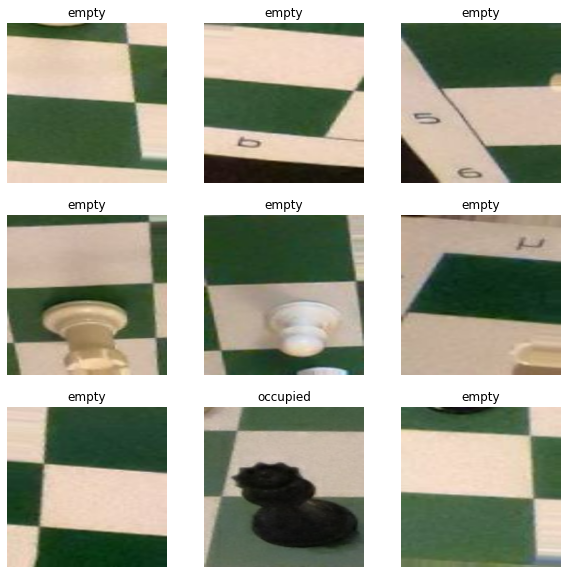

In [9]:
import matplotlib.pyplot as plt

class_names = train_img.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_img.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## data augmentation and classification

In [17]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=5,
        rescale=1./255,
        horizontal_flip=True,
        fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(
    folder + '/train',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=True)
test_gen = test_datagen.flow_from_directory(
    folder + '/test',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=False)

Found 3620 images belonging to 2 classes.
Found 454 images belonging to 2 classes.


In [19]:
from keras.applications.vgg16 import VGG16
model1 = VGG16(weights='imagenet',include_top = False,classifier_activation= 'sodtmax')
model1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [20]:
base_model1 = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers from VGG16
for layer in base_model1.layers:
    layer.trainable = False
# Establish new fully connected block
x = base_model.output
x = Flatten()(x) 
x = Dense(500, activation='relu')(x) 
x = Dense(500, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [21]:
epochs = 10
history = model.fit(
    train_gen, 
    epochs=epochs,
    verbose = 1,
    validation_data=test_gen)
model.save_weights('model_VGG16.h5')

Epoch 1/10
114/114 [==============================] - 53s 434ms/step - loss: 0.1642 - categorical_accuracy: 0.9630 - val_loss: 0.0517 - val_categorical_accuracy: 0.9824
Epoch 2/10
114/114 [==============================] - 50s 439ms/step - loss: 0.0106 - categorical_accuracy: 0.9959 - val_loss: 0.0257 - val_categorical_accuracy: 0.9934
Epoch 3/10
114/114 [==============================] - 49s 425ms/step - loss: 0.0228 - categorical_accuracy: 0.9920 - val_loss: 0.0238 - val_categorical_accuracy: 0.9934
Epoch 4/10
114/114 [==============================] - 49s 430ms/step - loss: 0.0125 - categorical_accuracy: 0.9956 - val_loss: 0.0129 - val_categorical_accuracy: 0.9956
Epoch 5/10
114/114 [==============================] - 50s 435ms/step - loss: 0.0033 - categorical_accuracy: 0.9981 - val_loss: 0.0036 - val_categorical_accuracy: 0.9978
Epoch 6/10
114/114 [==============================] - 48s 420ms/step - loss: 4.4691e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0041 - val_categorical

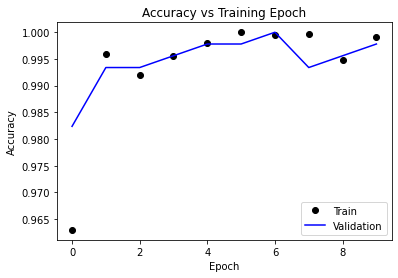

In [22]:
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(history.history['categorical_accuracy'], 'ko')
plt.plot(history.history['val_categorical_accuracy'], 'b')

plt.title('Accuracy vs Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation']);

15/15 [==============================] - 2s 138ms/step
False


<ipython-input-24-1defebe62ce9>:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  print((y_pred==target_names))


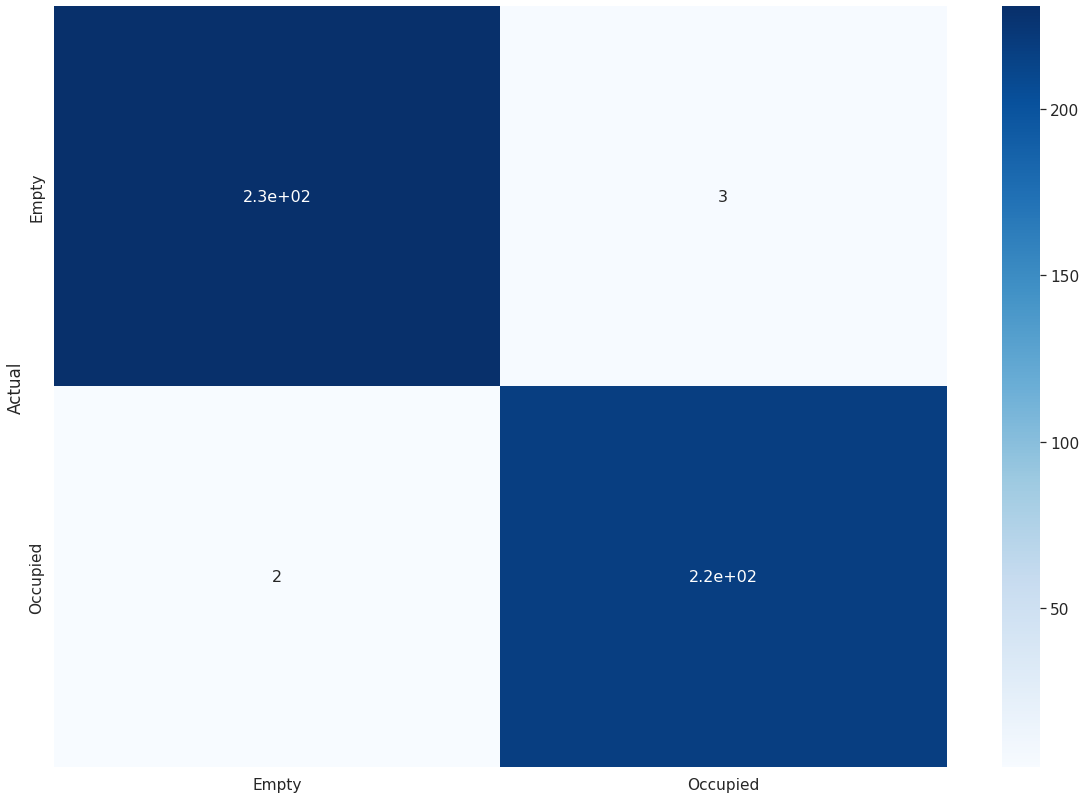

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['Empty', 'Occupied']

Y_pred = model.predict(test_img)
classes = test_gen.classes[test_gen.index_array]
y_pred = np.argmax(Y_pred, axis= -1)
print((y_pred==target_names))


data = confusion_matrix(classes, y_pred)
df_cm = pd.DataFrame(data, columns=target_names, index = target_names)
df_cm.index.name = 'Actual'
plt.figure(figsize = (20,14))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [25]:
print('Confusion Matrix')
print(data)
print('Classification Report')
print(classification_report(test_gen.classes[test_gen.index_array], y_pred, target_names=target_names))

Confusion Matrix
[[231   3]
 [  2 218]]
Classification Report
              precision    recall  f1-score   support

       Empty       0.99      0.99      0.99       234
    Occupied       0.99      0.99      0.99       220

    accuracy                           0.99       454
   macro avg       0.99      0.99      0.99       454
weighted avg       0.99      0.99      0.99       454



# Classifier pièces

In [ ]:
from IPython.display import Image
Image(url='https://www.chessgames.com/chessimages/fenhelp1.gif')

In [28]:
def classification(model, img_list):
    category_reference = {0: 'b', 1: 'k', 2: 'n', 3: 'p', 4: 'q', 5: 'r', 6: '1', 7: 'B', 8: 'K', 9: 'N', 10: 'P',
                          11: 'Q', 12: 'R'}
    pred_list = []
    for filename in img_filename_list:
        #Mettre image en sortie
        img = '/content/drive/MyDrive/Chess Pieces dataset/train/0301b7f9ed4d5ba503fda79fc4370c29_jpg.rf.56da1174519560712119d3fc195068cb.jpg'
        # Lancer le modèle qui préidt
        out = model.predict(img)
        # Classe la plus probable
        top_pred = 
        #Ajouter la prédiction 
        pred = ####[top_pred]
        pred_list.append(pred)

    fen = ''.join(pred_list)
    fen = fen[::-1]
    fen = '/'.join(fen[i:i + 8] for i in range(0, len(fen), 8))
    sum_digits = 0
    for i, p in enumerate(fen):
        if p.isdigit():
            sum_digits += 1
        elif p.isdigit() is False and (fen[i - 1].isdigit() or i == len(fen)):
            fen = fen[:(i - sum_digits)] + str(sum_digits) + ('D' * (sum_digits - 1)) + fen[i:]
            sum_digits = 0
    if sum_digits > 1:
        fen = fen[:(len(fen) - sum_digits)] + str(sum_digits) + ('D' * (sum_digits - 1))
    fen = fen.replace('D', '')
    return fen

SyntaxError: ignored